# Модуль 1 · intro: Введение в цифровое изображение

**Цели лекции**
- понять, что такое цифровое изображение и как оно хранится в памяти;
- вспомнить типы данных и диапазоны значений (uint8 vs float);
- увидеть отличие BGR/RGB и базовые конвертации цветов;
- разобраться с гистограммой яркости и простой коррекцией (контраст/гамма);
- увидеть эффект дискретизации (масштабирование и алиасинг). 

**Что понадобится**: `numpy`, `opencv-python` (cv2), `matplotlib`.

**Дальше по модулю**:
- Лекция 2: цветовые модели (RGB/HSV/Lab) — глубже и системно;
- Лекция 3: гистограммы, коррекция яркости/контраста;
- Лекция 4: дискретизация, квантование, разрешение, алиасинг.


## 1. Импорты и вспомогательные функции отображения
OpenCV хранит цветные изображения в формате **BGR**. Для корректного вывода в Matplotlib переведём их в **RGB**.

Мы также напишем простую функцию `show`, которая рисует изображения рядом и прячет оси.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple

def bgr2rgb(img: np.ndarray) -> np.ndarray:
    """Конвертация BGR -> RGB для корректного отображения в Matplotlib."""
    if img.ndim == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show(images: List[np.ndarray], titles: List[str] = None, cmap: str = None, figsize: Tuple[int,int]=(12,4)):
    """Отобразить список изображений в одной строке."""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(1, n, i+1)
        if im.ndim == 2:
            plt.imshow(im, cmap=cmap or 'gray')
        else:
            plt.imshow(bgr2rgb(im))
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 2. Что такое цифровое изображение
- **Градации серого**: матрица размера $H\times W$ (типично `uint8`, диапазон 0–255) или `float` (0–1).  
- **Цветное изображение**: тензор размера $H\times W\times 3$ для RGB/BGR.

Важно понимать тип данных (dtype) и диапазон значений — многие функции ожидают конкретный диапазон и могут давать неожиданные результаты при несоответствии.

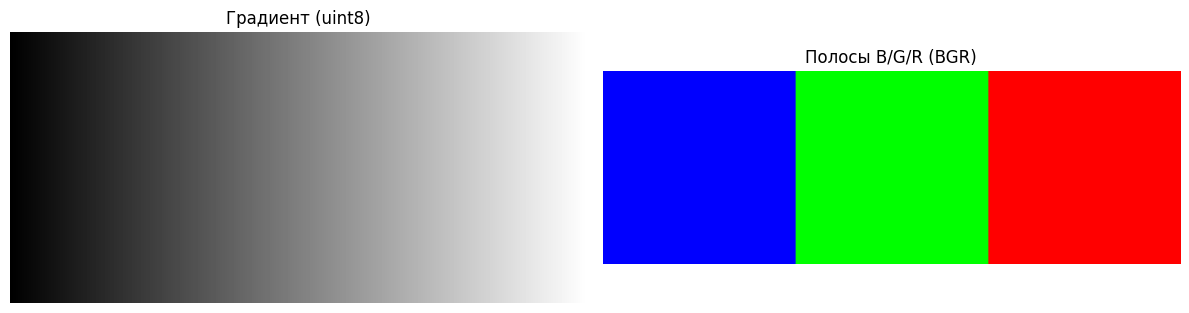

In [2]:
# Синтетическое «градиентное» изображение в оттенках серого
H, W = 120, 256
img_gray = np.tile(np.arange(W, dtype=np.uint8), (H, 1))  # значения 0..255 по ширине

# Цветное изображение с тремя полосами (B, G, R в BGR-представлении OpenCV)
img_color = np.zeros((100, 300, 3), dtype=np.uint8)
img_color[:, :100]   = (255, 0, 0)   # синяя полоса в BGR
img_color[:, 100:200] = (0, 255, 0)  # зелёная
img_color[:, 200:]   = (0, 0, 255)   # красная

show([img_gray, img_color], ["Градиент (uint8)", "Полосы B/G/R (BGR)"])

> **Замечание по типам**: Если привести изображение к `float32` и нормировать до [0,1], многие алгоритмы могут работать стабильнее, а операции коррекции выглядят прозрачнее (можно не следить за переполнением 0–255).

uint8 0 255
float32 0.0 1.0


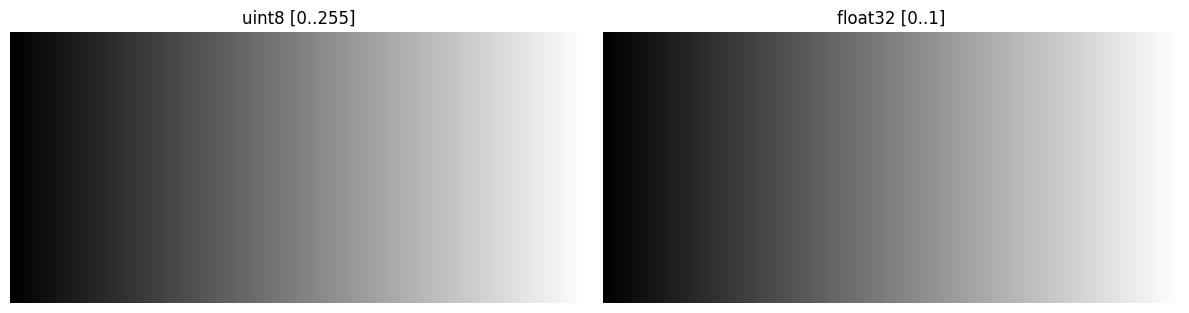

In [3]:
# Нормализация uint8 -> float32 в [0,1]
img_gray_f = img_gray.astype(np.float32) / 255.0
print(img_gray.dtype, img_gray.min(), img_gray.max())
print(img_gray_f.dtype, img_gray_f.min(), img_gray_f.max())
show([img_gray, img_gray_f], ["uint8 [0..255]", "float32 [0..1]"])

## 3. Цветовые представления и конвертация BGR↔RGB↔HSV
OpenCV по умолчанию использует BGR. Для анализа/визуализации часто удобен RGB или HSV.

- **RGB**: три канала красный/зелёный/синий.
- **HSV**: оттенок (Hue), насыщенность (Saturation), яркость (Value). Удобен для выделения цветов по диапазонам.

Ниже — демонстрация конвертации и работы с HSV-диапазонами на синтетическом изображении.

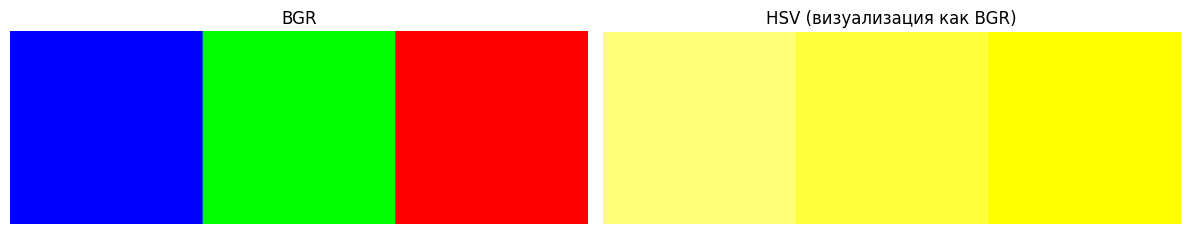

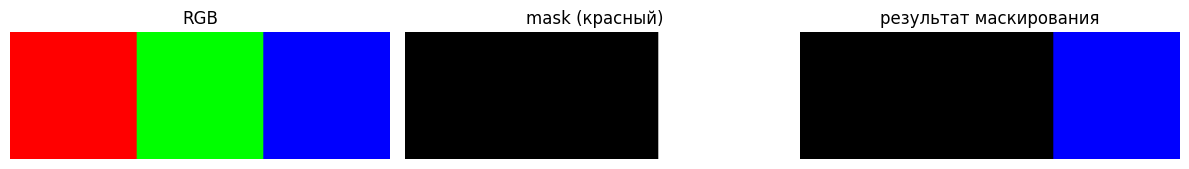

In [4]:
# Переводим нашу полосу BGR в HSV и обратно в RGB для отображения
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
show([img_color, img_hsv], ["BGR", "HSV (визуализация как BGR)"])  # HSV отрисуется условно

# Пример маскирования: выделим красную часть по HSV-диапазону
hsv = img_hsv.copy()
low_red1  = np.array([0, 100, 100])
high_red1 = np.array([10, 255, 255])
low_red2  = np.array([160, 100, 100])
high_red2 = np.array([179, 255, 255])

mask1 = cv2.inRange(hsv, low_red1, high_red1)
mask2 = cv2.inRange(hsv, low_red2, high_red2)
mask = cv2.bitwise_or(mask1, mask2)
res  = cv2.bitwise_and(img_color, img_color, mask=mask)

show([bgr2rgb(img_color), mask, bgr2rgb(res)], ["RGB", "mask (красный)", "результат маскирования"])

## 4. Гистограмма яркости и простая коррекция
Гистограмма показывает распределение значений яркости. На её основе можно делать:
- линейное растяжение контраста,
- гамма-коррекцию ($I_{out} = I_{in}^{\gamma}$, обычно на нормированных значениях),
- эквализацию (подробнее в отдельной лекции).

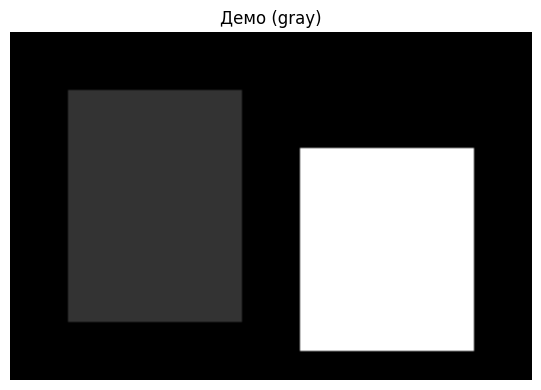

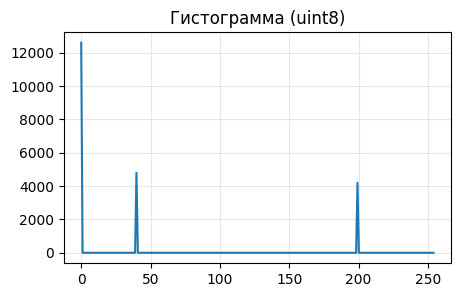

In [5]:
def plot_hist(img: np.ndarray, title: str = "Гистограмма"):
    """Построить гистограмму яркости для 8-битного или float изображения.
    Если 3 канала — переводим в градации серого для демонстрации."""
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    gray_f = gray.astype(np.float32)
    if gray.dtype == np.uint8:
        bins = 256
        hist, edges = np.histogram(gray, bins=bins, range=(0,255))
        x = edges[:-1]
    else:
        bins = 256
        hist, edges = np.histogram(np.clip(gray_f,0,1), bins=bins, range=(0,1))
        x = edges[:-1]
    plt.figure(figsize=(5,3))
    plt.plot(x, hist)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Синтетика: тёмное + светлое пятно
img_demo = np.zeros((120, 180), dtype=np.uint8)
img_demo[20:100, 20:80] = 40    # тёмный блок
img_demo[40:110, 100:160] = 200 # светлый блок
show([img_demo], ["Демо (gray)"])
plot_hist(img_demo, "Гистограмма (uint8)")

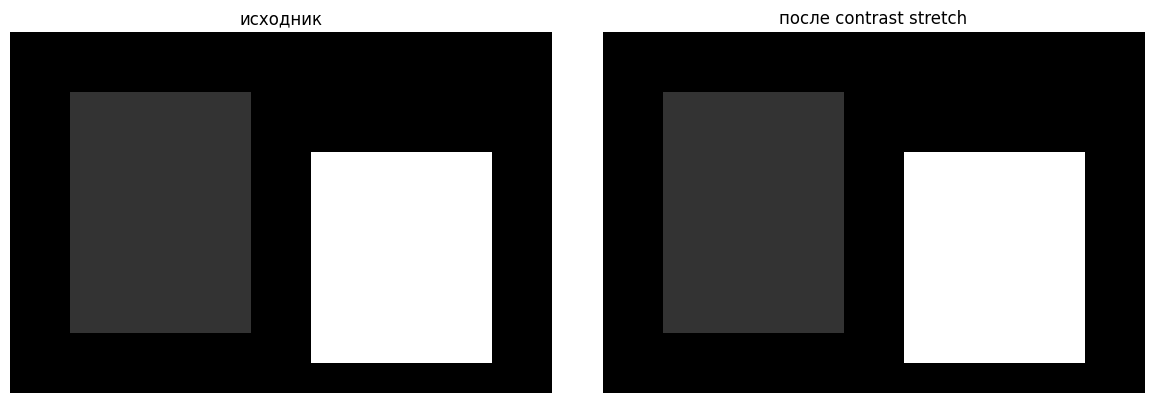

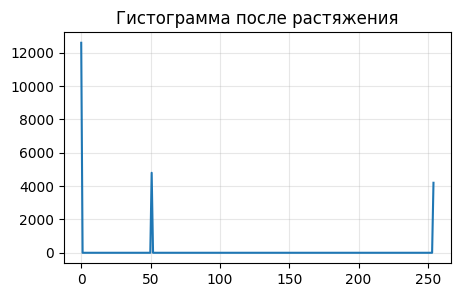

In [6]:
def contrast_stretch(img: np.ndarray) -> np.ndarray:
    """Линейное растяжение контраста на [0,255] для uint8 или [0,1] для float.
    Простая версия: по мин/макс без отсечения хвостов."""
    x = img.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-9:
        return img.copy()
    y = (x - mn) / (mx - mn)
    if img.dtype == np.uint8:
        y = np.clip(y*255.0, 0, 255).astype(np.uint8)
    return y

img_cs = contrast_stretch(img_demo)
show([img_demo, img_cs], ["исходник", "после contrast stretch"]) 
plot_hist(img_cs, "Гистограмма после растяжения")

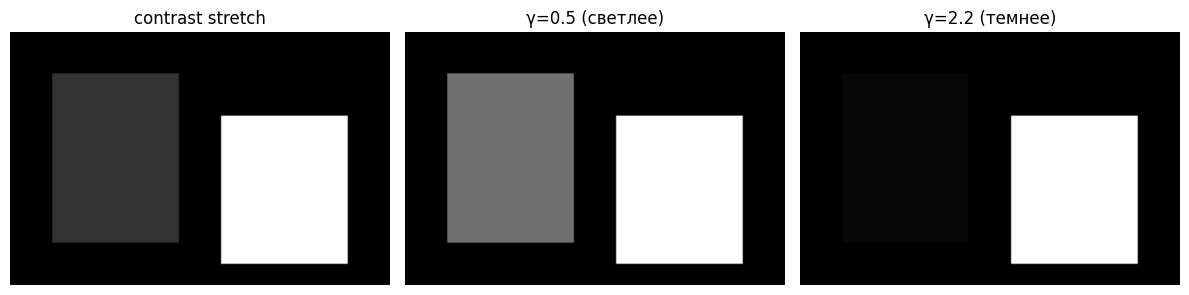

In [7]:
def gamma_correction(img: np.ndarray, gamma: float = 2.2) -> np.ndarray:
    """Гамма-коррекция. Работает как с uint8, так и с float изображениями."""
    if img.dtype == np.uint8:
        x = img.astype(np.float32) / 255.0
        y = np.power(np.clip(x,0,1), gamma)
        return np.clip(y*255.0, 0, 255).astype(np.uint8)
    else:
        x = img.astype(np.float32)
        y = np.power(np.clip(x,0,1), gamma)
        return y

img_gamma_low  = gamma_correction(img_cs, gamma=0.5)
img_gamma_high = gamma_correction(img_cs, gamma=2.2)
show([img_cs, img_gamma_low, img_gamma_high], ["contrast stretch", "γ=0.5 (светлее)", "γ=2.2 (темнее)"])

## 5. Дискретизация, масштабирование и алиасинг
При уменьшении изображения информация теряется: высокие частоты (мелкие детали) сглаживаются или складываются (алиасинг). Ниже — визуальная демонстрация: уменьшаем, затем увеличиваем обратно.

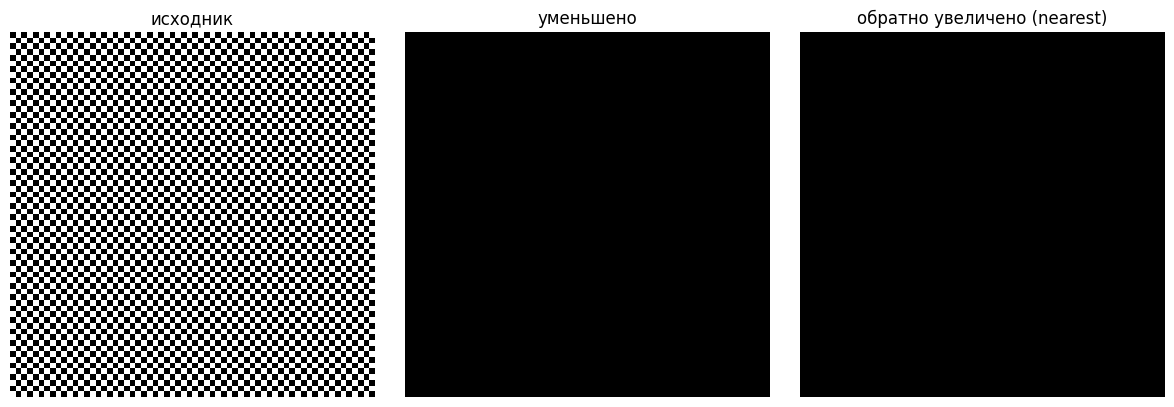

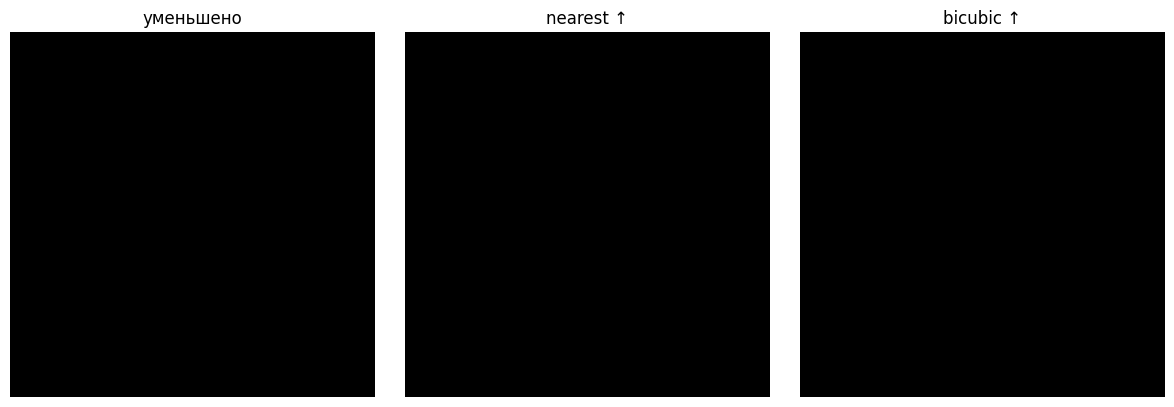

In [8]:
# Исходное синтетическое «шахматное» изображение
tile = 8
chess = np.indices((tile*8, tile*8)).sum(axis=0) % 2
chess = (chess * 255).astype(np.uint8)

# Уменьшаем сильно (интерполяция area — пригодна для downscale)
small = cv2.resize(chess, (chess.shape[1]//8, chess.shape[0]//8), interpolation=cv2.INTER_AREA)
# Возвращаем размер побольше (интерполяция nearest намеренно — чтобы подчеркнуть деградацию)
big_nearest = cv2.resize(small, (chess.shape[1], chess.shape[0]), interpolation=cv2.INTER_NEAREST)

show([chess, small, big_nearest], ["исходник", "уменьшено", "обратно увеличено (nearest)"])

# Попробуем bicubic при увеличении
big_cubic = cv2.resize(small, (chess.shape[1], chess.shape[0]), interpolation=cv2.INTER_CUBIC)
show([small, big_nearest, big_cubic], ["уменьшено", "nearest ↑", "bicubic ↑"])

## 6. Короткие вопросы для самопроверки
1. Чем отличается `uint8` представление изображения от `float32` и когда удобно переходить к float?
2. Зачем для matplotlib часто переводить BGR→RGB?
3. Что показывает гистограмма яркости? Как меняется гистограмма после линейного растяжения?
4. Что делает гамма-коррекция и почему её применяют на нормированных значениях?
5. Почему при сильном уменьшении изображений возникает потеря деталей/алиасинг?

**Мини-упражнение (не оценочное):**
- Реализуйте собственную функцию линейного контрастирования по 1%-клиппингу хвостов (обрежьте 1% darkest/brightest перед растяжением).
- Сгенерируйте синтетическое изображение с диагональным гридом и повторите эксперимент с уменьшением/увеличением (nearest/bilinear/bicubic).

## 7. Итоги и что дальше
- Мы определили цифровое изображение и его основные представления;
- вспомнили про типы данных и диапазоны;
- посмотрели на конвертации BGR↔RGB↔HSV, гистограмму и простую коррекцию;
- увидели эффект дискретизации.

Далее в модуле:
- **Лекция 2:** системно разбираем цветовые модели (RGB/HSV/Lab) на реальных примерах;
- **Лекция 3:** гистограммы, equalization, контраст и яркость на разных типах данных;
- **Лекция 4:** дискретизация, квантование, разрешение, алиасинг (теория + демо).
